<a href="https://colab.research.google.com/github/hanrach/marked-beetle-analysis/blob/main/Finalsims_EfficientNetB0_threshcropped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import glob
import shutil
import json
import keras
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from keras.preprocessing.image import ImageDataGenerator

import cv2
from sklearn.model_selection import train_test_split

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
filenames = os.listdir("/content/drive/MyDrive/GrayscaleThresholdBeetleImages")
filenames[:4]

['PaperedControl40v.tif',
 'PaperedControl41v.tif',
 'PaperedControl41v_light.tif',
 'PaperedControl41d.tif']

In [ ]:
train_images=[]
for filename in filenames:
    if 'light' not in filename:
      if filename.startswith('Papered') or filename.startswith('NoPapered'):
        train_images.append(filename)
print(f"Number of Train images: {len(train_images)}") #filename.startswith('Pink')

Number of Train images: 757


In [ ]:
test_images=[]
for filename in filenames:
    if filename.startswith('Trap'):
        test_images.append(filename)
print(f"Number of Test images: {len(test_images)}")

Number of Test images: 77


In [ ]:
categories = []
for filename in train_images:
    if filename.startswith('Papered') or filename.startswith('Pink') or filename.startswith('Trap'):
        categories.append('marked')
    if filename.startswith('NoPapered'):
        categories.append('unmarked')
len(categories)

757

In [ ]:
df = pd.DataFrame({
    'filename': train_images,
    'category': categories
})
df

,filename,category
0,PaperedControl40v.tif,marked
1,PaperedControl41v.tif,marked
2,PaperedControl41d.tif,marked
3,PaperedControl42v.tif,marked
4,PaperedControl42d.tif,marked
...,...,...
752,PaperedControl38v.tif,marked
753,PaperedControl38d.tif,marked
754,PaperedControl39v.tif,marked
755,PaperedControl39d.tif,marked


In [ ]:
df['category'].value_counts()

marked      479
unmarked    278
Name: category, dtype: int64

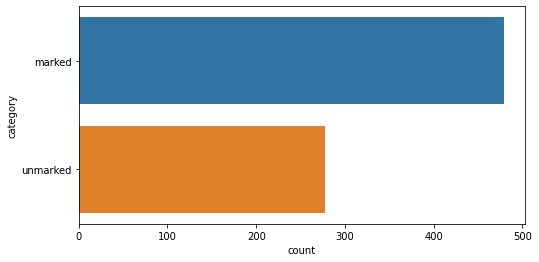

In [ ]:
plt.figure(figsize=(8, 4))
sns.countplot(y="category", data=df);

In [ ]:
image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", filenames[0]))
image.shape

(1944, 2592, 3)

In [ ]:
def visualize_batch(image_ids, labels):
    plt.figure(figsize=(16, 12))
    for ind, (image_id, label) in enumerate(zip(image_ids, labels)):
        plt.subplot(3, 3, ind+1 )
        image = cv2.imread(os.path.join("/content/drive/MyDrive/GrayscaleThresholdBeetleImages", image_id))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        plt.imshow(image)
        plt.title(f"{label}", fontsize=12)
        plt.axis("off")
    
    plt.show()

In [ ]:
tmp_df = df.sample(9)
tmp_df

,filename,category
739,PaperedControl32v.tif,marked
383,NoPaperedGreen54v.tif,unmarked
267,PaperedTransparent95v.tif,marked
526,NoPaperedMixed40d.tif,unmarked
263,PaperedTransparent93v.tif,marked
643,PaperedMixed49v.tif,marked
87,PaperedTransparent5v.tif,marked
41,PaperedControl61v.tif,marked
571,PaperedMixed13v.tif,marked


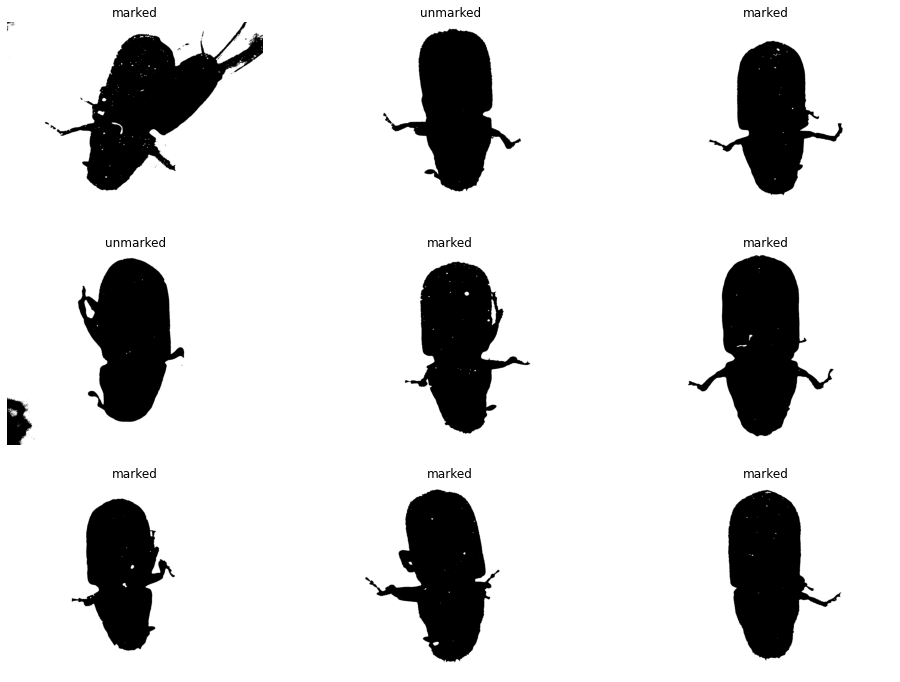

In [ ]:
image_ids = tmp_df["filename"].values
labels = tmp_df["category"].values

visualize_batch(image_ids, labels)

In [ ]:
#df["category"] = df["category"].replace({0: 'NotMarked', 1: 'Marked'}) 

In [ ]:
train_df, validate_df = train_test_split(df, test_size = 0.20, random_state = 42, stratify = df['category'])
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

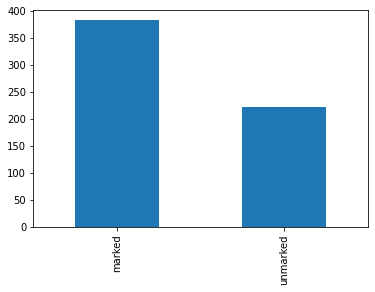

In [ ]:
train_df['category'].value_counts().plot.bar()

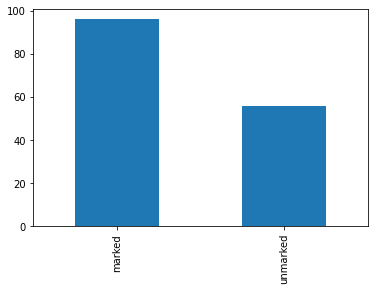

In [ ]:
validate_df['category'].value_counts().plot.bar()

In [ ]:
IMG_SIZE = 600
size = (IMG_SIZE,IMG_SIZE)
n_CLASS = 5
BATCH_SIZE = 50

In [ ]:
datagen_train = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')

In [ ]:
datagen_val = ImageDataGenerator(
                    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    )

In [ ]:
train_set = datagen_train.flow_from_dataframe(train_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 605 validated image filenames belonging to 2 classes.


In [ ]:
validate_set = datagen_val.flow_from_dataframe(validate_df,
                             directory = "/content/drive/MyDrive/GrayscaleThresholdBeetleImages",
                             seed=42,
                             x_col = 'filename',
                             y_col = 'category',
                             target_size = size,
                             #color_mode="rgb",
                             class_mode = 'categorical',
                             interpolation = 'nearest',
                             shuffle = True,
                             batch_size = BATCH_SIZE)

Found 152 validated image filenames belonging to 2 classes.


In [ ]:
from tensorflow.keras import layers
def unfreeze_model(model):
    # We unfreeze the top 20 layers while leaving BatchNorm layers frozen
    for layer in model.layers[-20:]:
        if not isinstance(layer, layers.BatchNormalization):
            layer.trainable = True

    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
    )

In [ ]:
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Flatten, Dense, Dropout, BatchNormalization, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import  Adam, RMSprop
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.applications import EfficientNetB0
def create_model():
    inputs = layers.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
    #model = EfficientNetB7(input_shape = (IMG_SIZE, IMG_SIZE, 3), include_top = False,
                            # weights = 'imagenet',
                             #drop_connect_rate=0.6)
    # Freeze the pretrained weights
    model.trainable = False

    # Rebuild top
    x = layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = layers.Flatten()(x)
    x = layers.BatchNormalization()(x)

    x = layers.Dense(256, activation = 'relu', bias_regularizer=tf.keras.regularizers.L1L2(l1=0.01, l2=0.001))(x)

    top_dropout_rate = 0.5
    x = layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = layers.Dense(2, activation="sigmoid", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    return model

model = create_model()
model.summary()

16719872/16705208 [==============================] - 0s 0us/step
Model: "EfficientNet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 600, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling (Rescaling)          (None, 600, 600, 3)  0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 600, 600, 3)  7           ['rescaling[0][0]']              
                                                                                                  
 stem_conv_pad (ZeroPa

In [ ]:
EPOCHS = 50
STEP_SIZE_TRAIN = train_set.n//train_set.batch_size
STEP_SIZE_VALID = validate_set.n//validate_set.batch_size

In [ ]:
def Model_fit():
    
    model = create_model()
    '''Compiling the model'''
    #unfreeze_model(model)
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits = False,
                                                   label_smoothing=0.0001,
                                                   name='categorical_crossentropy' )
    
    model.compile(optimizer = Adam(learning_rate = 1e-3),
                        loss = loss, #'categorical_crossentropy'
                        metrics = ['accuracy']) #'acc'
    
        # Stop training when the val_loss has stopped decreasing for 3 epochs.
    stop = EarlyStopping(monitor='val_loss', mode='min', patience=3,
                       restore_best_weights=True, verbose=1)
    
    # Save the model with the minimum validation loss
    checkpoint_cb = ModelCheckpoint("B0_original_images_model.h5",
                                    save_best_only=True,
                                    monitor = 'val_loss',
                                    mode='min')
    
    # reduce learning rate
    reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                                  factor = 0.2,
                                  patience = 2,
                                  min_lr = 1e-6,
                                  mode = 'min',
                                  verbose = 1)
    history = model.fit(train_set,
                             validation_data = validate_set,
                             epochs= EPOCHS,
                             batch_size = BATCH_SIZE,
                             #class_weight = d_class_weights,
                             steps_per_epoch = STEP_SIZE_TRAIN,
                             validation_steps = STEP_SIZE_VALID,
                             callbacks=[stop, checkpoint_cb, reduce_lr])
    model.save('/content/drive/MyDrive/finalsims_EB0_threshcropped.h5')  
    return history

In [ ]:
results = Model_fit()

Epoch 1/50
12/12 [==============================] - ETA: 0s - loss: 0.7291 - accuracy: 0.7099 

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


12/12 [==============================] - 410s 32s/step - loss: 0.7291 - accuracy: 0.7099 - val_loss: 0.4630 - val_accuracy: 0.8267 - lr: 0.0010
Epoch 2/50
12/12 [==============================] - 288s 24s/step - loss: 0.5748 - accuracy: 0.8000 - val_loss: 0.4952 - val_accuracy: 0.7933 - lr: 0.0010
Epoch 3/50
12/12 [==============================] - 292s 24s/step - loss: 0.5354 - accuracy: 0.8306 - val_loss: 0.4307 - val_accuracy: 0.8200 - lr: 0.0010
Epoch 4/50
12/12 [==============================] - 292s 26s/step - loss: 0.4212 - accuracy: 0.8468 - val_loss: 0.5789 - val_accuracy: 0.6867 - lr: 0.0010
Epoch 5/50
12/12 [==============================] - 285s 23s/step - loss: 0.5290 - accuracy: 0.8270 - val_loss: 0.4205 - val_accuracy: 0.8400 - lr: 0.0010
Epoch 6/50
12/12 [==============================] - 298s 25s/step - loss: 0.4349 - accuracy: 0.8317 - val_loss: 0.4354 - val_accuracy: 0.8067 - lr: 0.0010
Epoch 7/50
12/12 [==============================] - ETA: 0s - loss: 0.4177 - accu

In [ ]:
print('Train_Cat-Acc: ', max(results.history['accuracy']))
print('Val_Cat-Acc: ', max(results.history['val_accuracy']))

Train_Cat-Acc:  0.8576576709747314
Val_Cat-Acc:  0.8399999737739563


In [ ]:
print('Train_Cat-Loss: ', min(results.history['loss']))
print('Val_Cat-Loss: ', min(results.history['val_loss']))

Train_Cat-Loss:  0.4165039658546448
Val_Cat-Loss:  0.4204973876476288


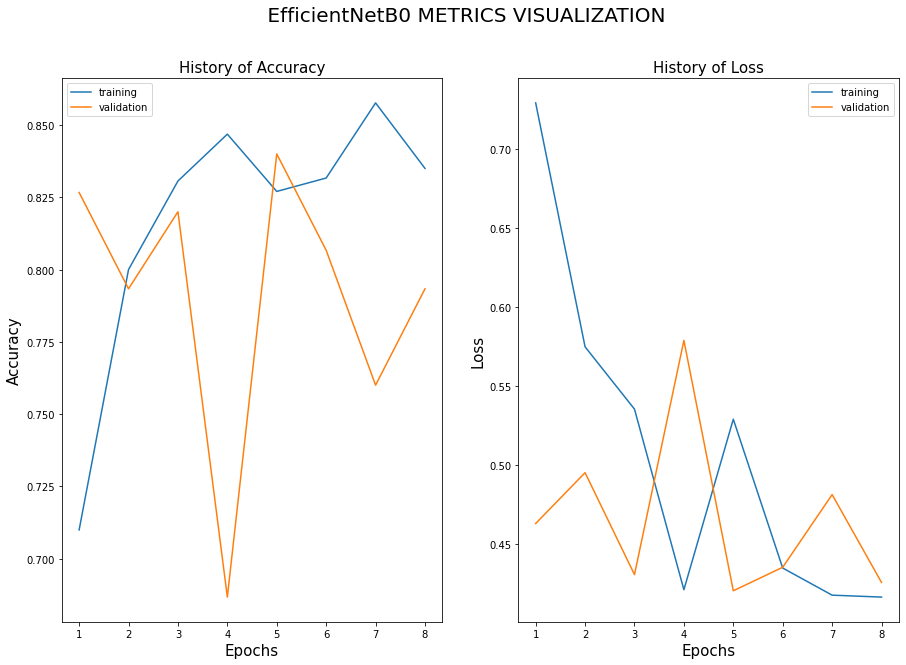

In [ ]:
def Train_Val_Plot(acc,val_acc,loss,val_loss):
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize= (15,10))
    fig.suptitle(" EfficientNetB0 METRICS VISUALIZATION ", fontsize=20)

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy', fontsize=15)
    ax1.set_xlabel('Epochs', fontsize=15)
    ax1.set_ylabel('Accuracy', fontsize=15)
    ax1.legend(['training', 'validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss', fontsize=15)
    ax2.set_xlabel('Epochs', fontsize=15)
    ax2.set_ylabel('Loss', fontsize=15)
    ax2.legend(['training', 'validation'])
    plt.show()
    

Train_Val_Plot(results.history['accuracy'],results.history['val_accuracy'],
               results.history['loss'],results.history['val_loss'])

In [ ]:
final_model = keras.models.load_model('/content/drive/MyDrive/finalsims_EB0_threshcropped.h5')

In [ ]:
tmp_df1=df.sample(10)
tmp_df1

,filename,category
711,PaperedControl18d.tif,marked
407,NoPaperedGreen66v.tif,unmarked
528,NoPaperedMixed41d.tif,unmarked
129,PaperedTransparent26v.tif,marked
637,PaperedMixed46v.tif,marked
166,PaperedTransparent44d.tif,marked
179,PaperedTransparent51v.tif,marked
329,NoPaperedGreen36d.tif,unmarked
362,NoPaperedGreen43d.tif,unmarked
567,PaperedMixed11v.tif,marked


In [ ]:
nb_samples = tmp_df1.shape[0]
nb_samples


10

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator = test_gen.flow_from_dataframe(
    tmp_df1, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 10 validated image filenames.


In [ ]:
predict = final_model.predict(test_generator, steps=np.ceil(nb_samples/BATCH_SIZE))

In [ ]:
tmp_df1['prediction'] = np.argmax(predict, axis=-1)
tmp_df1["prediction"] = tmp_df1["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
tmp_df1

,filename,category,prediction
711,PaperedControl18d.tif,marked,marked
407,NoPaperedGreen66v.tif,unmarked,unmarked
528,NoPaperedMixed41d.tif,unmarked,unmarked
129,PaperedTransparent26v.tif,marked,marked
637,PaperedMixed46v.tif,marked,marked
166,PaperedTransparent44d.tif,marked,marked
179,PaperedTransparent51v.tif,marked,marked
329,NoPaperedGreen36d.tif,unmarked,marked
362,NoPaperedGreen43d.tif,unmarked,marked
567,PaperedMixed11v.tif,marked,marked


In [ ]:
to_samples = df.shape[0]

In [ ]:
test_gen = ImageDataGenerator(preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
                    rotation_range = 40,
                    brightness_range = [0.3,0.9],
                    channel_shift_range = 50.0,
                    width_shift_range = 0.2,
                    height_shift_range = 0.2,
                    shear_range = 0.2,
                    zoom_range = 0.2,
                    horizontal_flip = True,
                    vertical_flip = True,
                    fill_mode = 'nearest')
test_generator1 = test_gen.flow_from_dataframe(
    validate_df, 
    "/content/drive/MyDrive/GrayscaleThresholdBeetleImages", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=size,
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 152 validated image filenames.


In [ ]:
predict = final_model.predict(test_generator1, steps=np.ceil(to_samples/BATCH_SIZE))

In [ ]:
predict

array([[0.6474968 , 0.4220068 ],
       [0.6610051 , 0.42700583],
       [0.61290973, 0.44616234],
       [0.6275035 , 0.4203977 ],
       [0.6593319 , 0.35889313],
       [0.6243343 , 0.4421334 ],
       [0.611995  , 0.44162816],
       [0.6408685 , 0.42218485],
       [0.6664017 , 0.4209127 ],
       [0.6238993 , 0.43609172],
       [0.66886556, 0.414843  ],
       [0.6571585 , 0.39492857],
       [0.6675406 , 0.4209996 ],
       [0.67372304, 0.40617383],
       [0.66512346, 0.42280555],
       [0.6778811 , 0.41752797],
       [0.6325986 , 0.39519584],
       [0.6769571 , 0.43139404],
       [0.5735667 , 0.3836609 ],
       [0.56794435, 0.41143546],
       [0.65925145, 0.35901737],
       [0.6647735 , 0.41575626],
       [0.6695958 , 0.41900116],
       [0.709595  , 0.33219695],
       [0.67141086, 0.42674923],
       [0.64255214, 0.42844936],
       [0.6749093 , 0.41144472],
       [0.5963977 , 0.39333272],
       [0.5901278 , 0.42491204],
       [0.65095687, 0.41552955],
       [0.

In [ ]:
validate_df['prediction'] = np.argmax(predict, axis=-1)
validate_df["prediction"] = validate_df["prediction"].replace({1: 'unmarked', 0: 'marked'}) 
validate_df

,filename,category,prediction
0,PaperedControl65d.tif,marked,marked
1,NoPaperedMixed38v.tif,unmarked,marked
2,NoPaperedGreen43v.tif,unmarked,marked
3,NoPaperedMixed7v.tif,unmarked,marked
4,PaperedTransparent28d.tif,marked,marked
...,...,...,...
147,PaperedMixed9v.tif,marked,marked
148,NoPaperedGreen61v.tif,unmarked,unmarked
149,NoPaperedGreen57d.tif,unmarked,unmarked
150,PaperedTransparent5d.tif,marked,marked


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_true=list(validate_df['category'])
y_pred=list(validate_df['prediction'])
cm=confusion_matrix(y_true, y_pred, labels=["marked", "unmarked"])

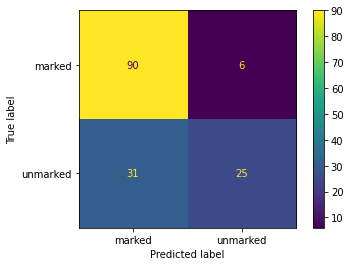

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["marked", "unmarked"])
disp.plot(values_format="d") 

In [ ]:
validation_accuracy=(cm[0,0]+cm[1,1])/(cm[0,0]+cm[1,0]+cm[0,1]+cm[1,1])
validation_accuracy


0.756578947368421